This notebook shows how to apply **modification** functions to an **SDF** field and calculate the **gradient** of the **SDF** field with respect to the **parameters** of the **modification**, or the **SDF** function.

# IMPORTS

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from jax import jvp, jacfwd
import jax.numpy as jnp
from jax.scipy.spatial.transform import Rotation

from spomso.cores.helper_functions import generate_grid, smarter_reshape

from spomso.jax_cores.sdf_3D_jax import sdf_arc_3d

from spomso.jax_cores.modifications_jax import elongation, onion, concentric

from spomso.jax_cores.combine_jax import combine_2_sdfs, parametric_combine_2_sdfs
from spomso.jax_cores.combine_jax import union2, smooth_union2_3o

from spomso.jax_cores.transformations_jax import compound_euclidian_transform_sdf
from spomso.jax_cores.post_processing_jax import gaussian_falloff_jax

# PARAMETERS

In [2]:
# size of the volume
co_size = 6, 6, 6
# resolution of the volume
co_resolution = 100, 100, 100

# FIELD, PROJECTED,
show = "PROJECTED"
show_midplane = True
show_3d = True

# compute the gradient with respect to one of the parameters
compute_gradient = True

# COORDINATE SYSTEM

Point cloud of coordinates is created with the **generate_grid** function, which takes the size of the coordinate system and the number of points in each direction (**co_resolution**).

In [3]:
coor, co_res_new = generate_grid(co_size, co_resolution)

If there is an even number of points along any direction the function will automatically convert it to an odd number, therefore the origin is always included in the point cloud. The point cloud is a **numpy.ndarray** with a shape of **(D, N)**, where **D** is the number of dimensions and **N** is the number of data points.

# CREATE SDFs

Define the radius of the **arcs**, the twist **angle** (degrees), the concentric **width**, and the **smoothing distance** of the **smooth union** combine operation:

In [4]:
radius = 2.
angle = 30.
width = 0.5
smooth = 1.8

p = radius, angle, width, smooth

Define a new **SDF** where the **radius**, **angle**, **width**, and **smoothing distance** are the parameters:

In [5]:
def geometry(r, a, w, s):
    sdf = sdf_arc_3d
    sdf_p = r, 0., np.pi*5/6, -np.pi*5/6

    f_modified = concentric(sdf, w)
    f_modified = elongation(f_modified, jnp.asarray([0., 0., 0.75]))

    rot_mat_p = Rotation.from_euler('z', a, degrees=True).as_matrix()
    f_modified_1 = compound_euclidian_transform_sdf(f_modified, rot_mat_p, jnp.asarray([0, 0, 1.5]), 1.2)

    rot_mat_m = Rotation.from_euler('z', -a, degrees=True).as_matrix()
    f_modified_2 = compound_euclidian_transform_sdf(f_modified, rot_mat_m, jnp.asarray([0, 0, -1.5]), 1.2)

    csdf = combine_2_sdfs(f_modified_1, f_modified_2, sdf_p, sdf_p, union2)
    csdf = parametric_combine_2_sdfs(csdf, f_modified, (), sdf_p, smooth_union2_3o, s)

    out = onion(csdf, 0.1)(coor, ())
    return out



## EVALUATE

Evaluate the **SDF** of the **geometry** to create a signed distance field 2D map and convert into a 2D image:

In [6]:
final = geometry(*p)
field = smarter_reshape(final, co_resolution)

Compute the **Jacobian** with respect to one of the parameters (arguments):
- **Radius** of the structure (arg_number=0) 
- rotation **angle** in degrees (arg_number=1)
- concentric **width** (arg_number=2) 
- smoothing distance of the **smooth** union (arg_number=3)

In [7]:
arg_number = 3
if compute_gradient:
    final_gradient = jacfwd(geometry, argnums=arg_number)(*p)
    gradient_field = smarter_reshape(final_gradient, co_resolution)

# PROJECTION

**Project** the **SDF** to another scalar field using a **post-processing** function:

In [8]:
if show == "PROJECTED" and compute_gradient:
    gf, grad_gf = jvp(gaussian_falloff_jax, (final, 1.0, 0.1), (final_gradient, 0., 0.))
    field, gradient_field = smarter_reshape(gf, co_resolution), smarter_reshape(grad_gf, co_resolution)
if show == "PROJECTED" and not compute_gradient:
    gf = gaussian_falloff_jax(final, 1.0, 0.1)
    field = smarter_reshape(gf, co_resolution)

# PLOT

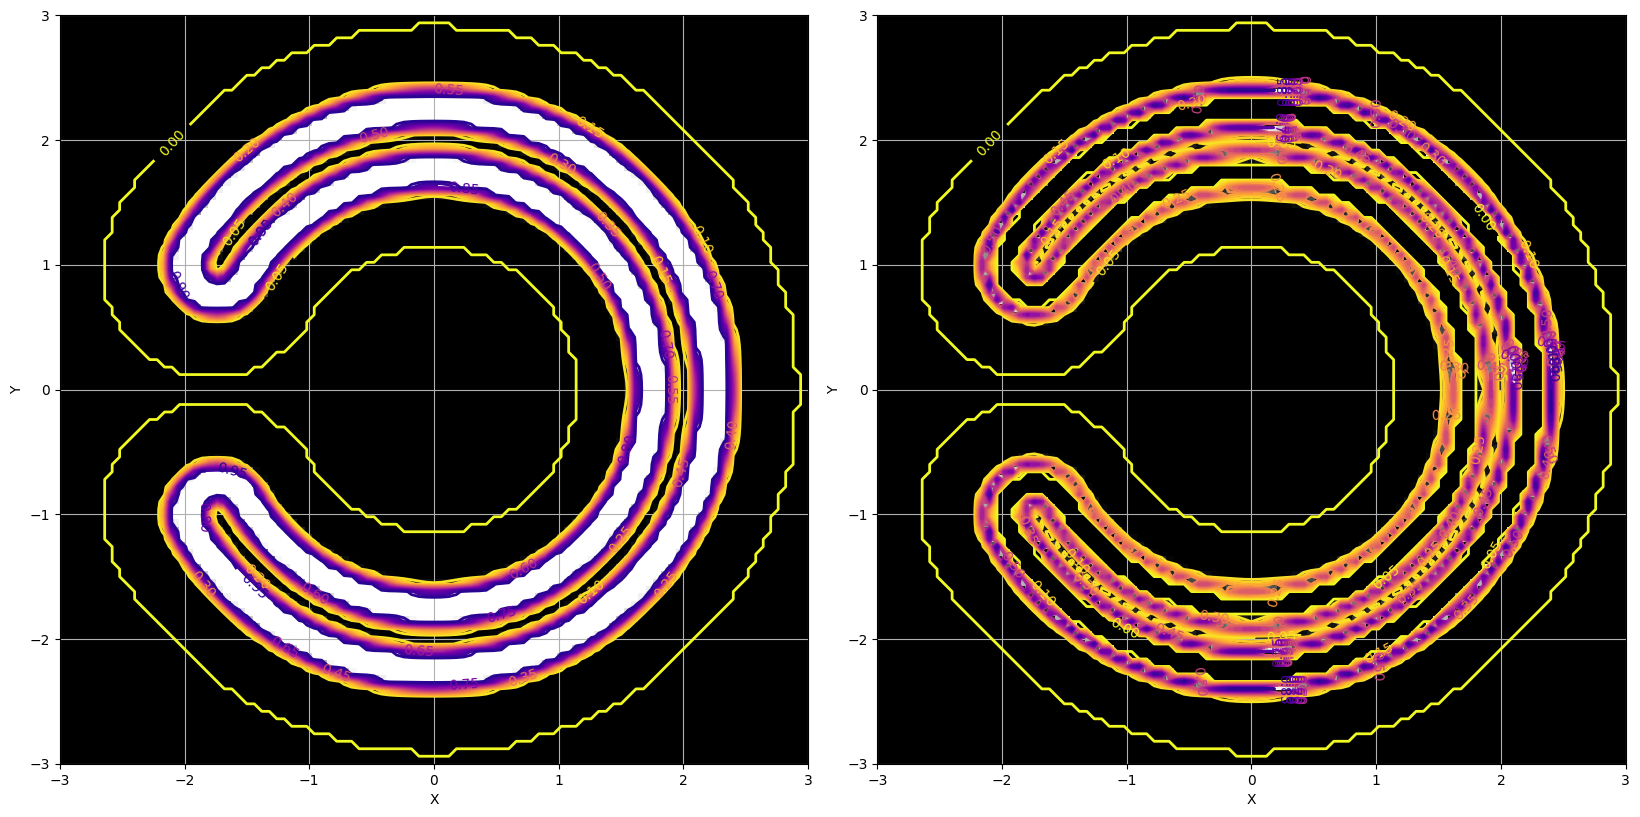

In [9]:
if show_midplane:
    fig, axs = plt.subplots(1, (1 + compute_gradient), figsize=(8.25*(1 + compute_gradient), 8.25))

    if compute_gradient:
        ax = axs[0]
    else:
        ax = axs

    # FIELD
    f = field[:, :, field.shape[2] // 2]
    ax.imshow(f.T,
              cmap="binary_r",
              extent=(-co_size[0] / 2, co_size[0] / 2,
                      -co_size[1] / 2, co_size[1] / 2),
              origin="lower"
              )
    z_mask = coor[2] == 0
    cs1 = ax.contour(coor[0, z_mask].reshape(co_res_new[0], co_res_new[1]),
                         coor[1, z_mask].reshape(co_res_new[0], co_res_new[1]),
                         f,
                         cmap="plasma_r",
                         linewidths=2,
                         levels=21)
    ax.clabel(cs1, inline=True, fontsize=10)
    ax.grid()

    ax.set_xlabel("X")
    ax.set_ylabel("Y")

    # GRADIENT
    if compute_gradient:
        axs[1].imshow(gradient_field[:, :, field.shape[2]//2].T,
                      cmap="binary_r",
                      extent=(-co_size[0] / 2, co_size[0] / 2,
                              -co_size[1] / 2, co_size[1] / 2),
                      origin="lower"
                      )
        cs2 = axs[1].contour(coor[0, z_mask].reshape(co_res_new[0], co_res_new[1]),
                             coor[1, z_mask].reshape(co_res_new[0], co_res_new[1]),
                             gradient_field[:, :, field.shape[2]//2],
                             cmap="plasma_r",
                             linewidths=2,
                             levels=21)
        axs[1].clabel(cs2, inline=True, fontsize=10)
        axs[1].grid()

        axs[1].set_xlabel("X")
        axs[1].set_ylabel("Y")

    fig.tight_layout()
    plt.show()

In [ ]:
if show_3d:
    if compute_gradient:
        patterns = (field, gradient_field)
        titles = ("Field", "Gradient")
        fig = make_subplots(rows=1, cols=2,
                            specs=[[{'is_3d': True}, {'is_3d': True}]],
                            subplot_titles=titles
                            )
    else:
        patterns = (field, )
        titles = ("Field", )
        fig = make_subplots(rows=1, cols=1,
                            specs=[[{'is_3d': True}]],
                            subplot_titles=titles
                            )

    for j in range(len(titles)):
        fig.add_trace(go.Volume(
            x=coor[0],
            y=coor[1],
            z=coor[2],
            isomin=float(patterns[j].min()),
            isomax=float(patterns[j].max()),
            opacityscale='max' if show == "PROJECTED" else 'min',
            value=patterns[j].flatten(),
            opacity=0.75,
            surface_count=10 if not show == "PROJECTED" else 3),
            1, 1 + j,
            )

    fig.update_layout(
        scene=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z',
            aspectmode='cube'
        )
    )
    fig.show()
